# Setting up Google Colab & Github

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/TweetAnalysis/

/content/drive/MyDrive/TweetAnalysis


# Import

In [3]:
pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn
import nltk
from nltk.corpus import stopwords
from collections import  Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk


import wordcloud, textstat

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
import string

import gensim.downloader
from gensim.models import Word2Vec,KeyedVectors
from gensim.utils import simple_preprocess

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer


In [7]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load data

In [8]:
df_train = pd.read_csv("./data/train.csv",encoding='unicode_escape')
df_test = pd.read_csv("./data/test.csv",encoding= 'unicode_escape')

df_train.dropna(inplace=True)
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [9]:
df_test.dropna(inplace=True)
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


# Part 1 : Analysis of the text dataset

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

## First look on the train dataset

In [10]:
df_train.shape

(27480, 10)

In [11]:
df_train.dtypes

textID               object
text                 object
selected_text        object
sentiment            object
Time of Tweet        object
Age of User          object
Country              object
Population -2020      int64
Land Area (Km²)     float64
Density (P/Km²)       int64
dtype: object

In [12]:
df_train = df_train[["textID","text","sentiment"]]
df_train.head()

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


## Analyzing text statistics

### Str length per tweet histogram

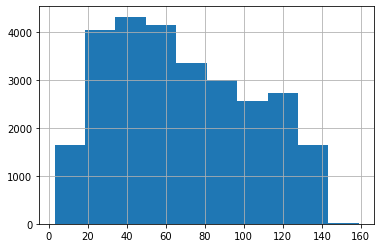

In [13]:
df_train['text'].str.len().hist()

### Nb of word per tweet hist

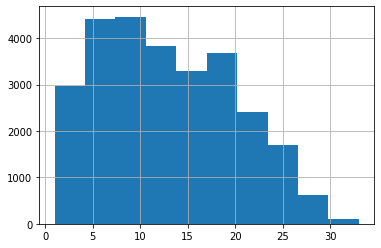

In [14]:
df_train['text'].str.split().map(lambda x: len(x)).hist()

### Average word length per tweet hist

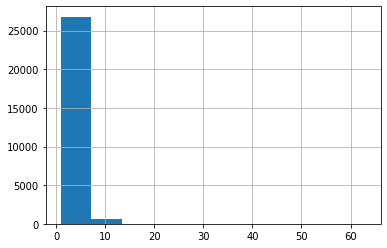

In [15]:
df_train["text"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

### Plotting the top stopwords

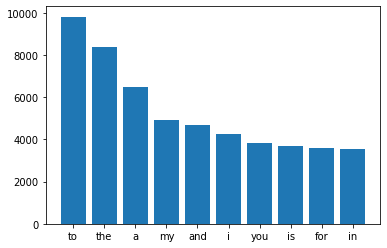

In [16]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
    
plot_top_stopwords_barchart(df_train["text"])

### Plotting top non_stopwords

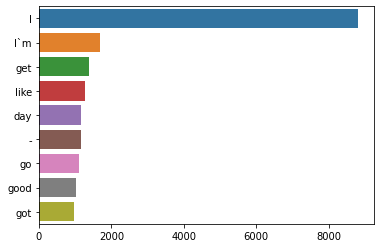

In [17]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)
    
plot_top_non_stopwords_barchart(df_train["text"])

## N-gram exploration

In [18]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

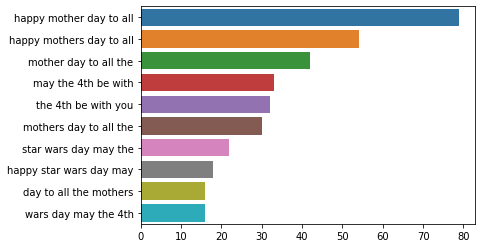

In [19]:
plot_top_ngrams_barchart(df_train[df_train["sentiment"]=="positive"]["text"],5)

## Wordcloud

In [20]:
def plot_wordcloud(text):
    stop=set(stopwords.words('english'))
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]
            words=[lem.lemmatize(w) for w in words if len(w)>2]
            corpus.append(words)
        return corpus
    corpus=_preprocess_text(text)
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    wordcloud=wordcloud.generate(str(corpus))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

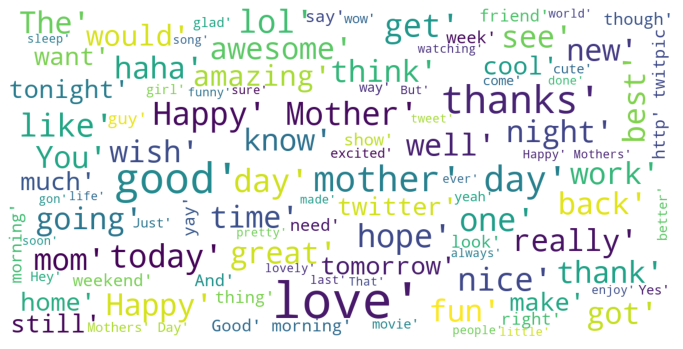

In [21]:
plot_wordcloud(df_train[df_train["sentiment"]=="positive"]['text'])

# Part 2 : Text processing and transformation 

## Setting up y_train and y_test

In [22]:
y_train = df_train["sentiment"].values
y_test = df_test["sentiment"].values

## Lemmatize & Tokenize

Artificial class that lemmatize & tokenize 

In [23]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, tweets):
        return [self.wnl.lemmatize(t) for t in word_tokenize(tweets)]

lm = LemmaTokenizer()
final_stopwords_list = stopwords.words('english') + list(string.punctuation)

In [24]:
lm("My name is changing ! I changed id")

['My', 'name', 'is', 'changing', '!', 'I', 'changed', 'id']

## Feature extraction

In [25]:
def bow_feature_extraction(df, vectorizer,test=False):
    if not test:
        vectorizer.fit(df["text"])
    
    X_ = np.array(vectorizer.transform(df["text"]).todense())
    return X_

### Bag of word approach for simple embeddings

In [26]:
count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), 
                                   strip_accents = 'unicode',  
                                   stop_words = final_stopwords_list, # works
                                   lowercase = True, # works
                                   max_df = 0.5, # works
                                   min_df = 10)

In [27]:
X_bow_train = bow_feature_extraction(df_train,count_vectorizer)
X_bow_test = bow_feature_extraction(df_test,count_vectorizer,test=True)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


# Part 3 : Applying different embedding techniques

## TF-IDF approach

In [28]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                   strip_accents = 'unicode', # works 
                                   stop_words = final_stopwords_list, # works
                                   lowercase = True, # works
                                   max_df = 0.5, # works
                                   min_df = 10)

In [29]:
X_tfidf_train = bow_feature_extraction(df_train,tfidf_vectorizer)
X_tfidf_test = bow_feature_extraction(df_test,tfidf_vectorizer,test=True)

## Word2Vec approach

### GloVe method

#### Load model

In [30]:
display(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [31]:
glove_vectors = KeyedVectors.load("./glove_model/glove-twitter-200.model")

#### Extract features

In [32]:
def glove_feature_extraction(df):
    tokenized_data = [simple_preprocess(sentence, deacc=True) for sentence in df['text']] 
    def mean_glove_vector(tokenized_sentence) :
        temp = []
        if len(tokenized_sentence) != 0 :
          for word in tokenized_sentence :
              vector = glove_vectors[word] if word in glove_vectors else glove_vectors['of']
              temp.append(vector)
          return np.mean(temp,axis=0)
        else : return np.zeros(200, dtype=np.float32)
    return np.array([mean_glove_vector(tokenized_sentence) for tokenized_sentence in tokenized_data])

In [33]:
X_glove_train = glove_feature_extraction(df_train)
X_glove_test = glove_feature_extraction(df_test)

# Part 4 : Classification on embedded data

## Logistic regression model

### TF-IDF evaluation

In [34]:
clf = LogisticRegression(multi_class='multinomial',max_iter=10000)

clf.fit(X_tfidf_train, y_train)
y_pred = clf.predict(X_tfidf_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.71      0.64      0.67      1001
     neutral       0.64      0.74      0.69      1430
    positive       0.80      0.70      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.72      0.70      0.70      3534
weighted avg       0.71      0.70      0.70      3534



### GloVe evaluation

In [35]:
clf = LogisticRegression(multi_class='multinomial',max_iter=10000)

clf.fit(X_glove_train, y_train)
y_pred = clf.predict(X_glove_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.70      0.61      0.65      1001
     neutral       0.59      0.69      0.64      1430
    positive       0.74      0.66      0.70      1103

    accuracy                           0.66      3534
   macro avg       0.68      0.65      0.66      3534
weighted avg       0.67      0.66      0.66      3534



## BERT approach

https://medium.com/nerd-for-tech/fine-tuning-pretrained-bert-for-sentiment-classification-using-transformers-in-python-931ed142e37

https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf



### Prepare the data

#### Load data

In [36]:
train_eval_dataset = Dataset.from_pandas(df_train).train_test_split(test_size=0.25)

train_dataset = train_eval_dataset["train"]
eval_dataset = train_eval_dataset["test"]
test_dataset = Dataset.from_pandas(df_test)

#### Load tokenizer

In [37]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

#### Transform data

In [38]:
def transform_labels(label):
    label = label['sentiment']
    num = 0
    if label == 'negative':
        num = 0
    elif label == 'neutral':
        num = 1
    elif label == 'positive':
        num = 2
    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['text'], padding='max_length')

train_dataset = train_dataset.map(tokenize_data, batched=True)
eval_dataset = eval_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)


remove_columns = ['textID','sentiment']

train_dataset = train_dataset.map(transform_labels, remove_columns=remove_columns)
eval_dataset = eval_dataset.map(transform_labels, remove_columns=remove_columns)
test_dataset = test_dataset.map(transform_labels, remove_columns=remove_columns)

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/20610 [00:00<?, ?ex/s]

  0%|          | 0/6870 [00:00<?, ?ex/s]

  0%|          | 0/3534 [00:00<?, ?ex/s]

### Prepare model



#### Set fine tuning parameters

In [39]:
training_args = TrainingArguments("test_trainer", num_train_epochs=3)

In [40]:
# if model is on hugging face Hub
#model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

# from local folder
model = AutoModelForSequenceClassification.from_pretrained("./test/saved_model/")

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [42]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    #recall = recall_score(y_true=labels, y_pred=pred)
    #precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy": accuracy,"f1_score":f1}

In [43]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=train_dataset, 
                  eval_dataset=eval_dataset,
                  compute_metrics=compute_metrics,
)

#### Launch fine tuning (train)

In [44]:
try : 
  trainer.train(resume_from_checkpoint = True)
except : 
  trainer.train()

Loading model from test_trainer/checkpoint-10000.
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20610
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7731
  Number of trainable parameters = 108312579
  Continuing training from checkpoint, will skip to s

  0%|          | 0/2269 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




Step,Training Loss


In [45]:
trainer.save_model("./test/saved_model/")

Saving model checkpoint to ./test/saved_model/
Configuration saved in ./test/saved_model/config.json
Model weights saved in ./test/saved_model/pytorch_model.bin


#### Check if model is overfitting

In [46]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6870
  Batch size = 8


{'eval_loss': 0.18385300040245056,
 'eval_accuracy': 0.9480349344978166,
 'eval_f1_score': 0.9480019930987266,
 'eval_runtime': 57.7407,
 'eval_samples_per_second': 118.98,
 'eval_steps_per_second': 14.877,
 'epoch': 2.91}

### Evaluate model predictions

#### Prepare vector of prediction

In [47]:
preds = trainer.predict(test_dataset=test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Land Area (Km²), Age of User, text, Density (P/Km²), Country, Time of Tweet, Population -2020, __index_level_0__. If Land Area (Km²), Age of User, text, Density (P/Km²), Country, Time of Tweet, Population -2020, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3534
  Batch size = 8


In [48]:
probs = torch.from_numpy(preds[0]).softmax(1)
probabilities = probs.numpy() # convert tensors to numpy array
predictions = np.argmax(probabilities,axis=1).tolist()

for i, n in enumerate(predictions):
  if n == 0 :
    predictions[i] = "negative"
  elif n == 1:
    predictions[i] = "neutral"
  else : # n == 2
    predictions[i] = "positive"

### BERT evaluation

In [49]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.75      0.82      0.79      1001
     neutral       0.77      0.73      0.75      1430
    positive       0.84      0.81      0.82      1103

    accuracy                           0.78      3534
   macro avg       0.79      0.79      0.79      3534
weighted avg       0.79      0.78      0.78      3534

